In [42]:
%%capture

# Install Dependencies if you haven't already.
!pip install pandas
!pip install scikit-learn
!pip install pmdarima
!clear

# Import Neccessary Libraries
import pandas as pd
import numpy as np

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

from IPython.display import clear_output

clear_output(wait=True)

In [7]:
df = pd.read_csv('client-raw-data/csv/sales-history-delhi-5yrs.csv')
df.head()

,Voucher Number,Reference,Date,Voucher Type,Party Name,Party Alias,Buyer's TIN No.,CST Number,Item Name,Godown,...,Alternate Billed Quantity,Rate,Purchase Rate,Unit,Discount,Discount Amount,Margin,Amount,Purchase/Sales Ledger,Narration
0,PFIDEL001/18-19,PFIDEL001/17-18,3-Apr-18,Sales,Prem Enviromantel Solutions,NaN,03262165823,NaN,"20"" BB L -1""",Main Location,...,NaN,420.0,355.0,Nos,0,NaN,942.82,5040.0,IGST Sale,NaN
1,PFIDEL001/18-19,PFIDEL001/17-18,3-Apr-18,Sales,Prem Enviromantel Solutions,NaN,03262165823,NaN,MEMFLO-4-300-2,Main Location,...,NaN,2700.0,2400.0,Nos,0,NaN,1936.11,13500.0,IGST Sale,NaN
2,PFIDEL001/18-19,PFIDEL001/17-18,3-Apr-18,Sales,Prem Enviromantel Solutions,NaN,03262165823,NaN,"SPG 1354-2.5"" T",Main Location,...,NaN,3100.0,2881.0,Nos,0,NaN,1914.87,18600.0,IGST Sale,NaN
3,PFIDEL002/18-19,PFIDEL002/17-18,3-Apr-18,Sales,Jal Jeevan Engineers,NaN,07670425885,NaN,"FRP 3072 - 4""TB",Main Location,...,NaN,24000.0,20663.0,Nos,0,NaN,6674.00,48000.0,SCGST Sale,NaN
4,PFIDEL002/18-19,PFIDEL002/17-18,3-Apr-18,Sales,Jal Jeevan Engineers,NaN,07670425885,NaN,"FRP 3672 - 4""TB",Main Location,...,NaN,32000.0,26330.0,Nos,0,NaN,11340.00,64000.0,SCGST Sale,NaN


In [8]:
# Replace 'column_to_drop_1' and 'column_to_drop_2' with the names of the columns you want to drop
df = df.drop(['Voucher Number', # Just the Invoice Number Sequentially
              'Reference', # Almost All Empty
              'Voucher Type', # All Same (Sales)
              'Party Alias', # All Empty
              "Buyer's TIN No.", # Many Empty, Correlated to 'Party Name'
              'CST Number', # > 80% All Empty
              'Godown', # All Same (Main-Location)
              'Item Batch', # All Same (Primary-Batch)
              'Acutal Quantity', # All Same as 'Billed Qty'
              'Alternate Actual Quantity', # All-Empty
              'Alternate Billed Quantity', # All-Empty
              'Unit', # All-Same (Nos)
              'Discount', # All-Empty
              'Discount Amount', # All-Empty
              'Narration', # All-Empty
             ], axis=1)
df.head()

,Date,Party Name,Item Name,Billed Quantity,Rate,Purchase Rate,Margin,Amount,Purchase/Sales Ledger
0,3-Apr-18,Prem Enviromantel Solutions,"20"" BB L -1""",12.0,420.0,355.0,942.82,5040.0,IGST Sale
1,3-Apr-18,Prem Enviromantel Solutions,MEMFLO-4-300-2,5.0,2700.0,2400.0,1936.11,13500.0,IGST Sale
2,3-Apr-18,Prem Enviromantel Solutions,"SPG 1354-2.5"" T",6.0,3100.0,2881.0,1914.87,18600.0,IGST Sale
3,3-Apr-18,Jal Jeevan Engineers,"FRP 3072 - 4""TB",2.0,24000.0,20663.0,6674.00,48000.0,SCGST Sale
4,3-Apr-18,Jal Jeevan Engineers,"FRP 3672 - 4""TB",2.0,32000.0,26330.0,11340.00,64000.0,SCGST Sale


In [9]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

df.head()

,Party Name,Item Name,Billed Quantity,Rate,Purchase Rate,Margin,Amount,Purchase/Sales Ledger
Date,,,,,,,,
2018-04-03,Prem Enviromantel Solutions,"20"" BB L -1""",12.0,420.0,355.0,942.82,5040.0,IGST Sale
2018-04-03,Prem Enviromantel Solutions,MEMFLO-4-300-2,5.0,2700.0,2400.0,1936.11,13500.0,IGST Sale
2018-04-03,Prem Enviromantel Solutions,"SPG 1354-2.5"" T",6.0,3100.0,2881.0,1914.87,18600.0,IGST Sale
2018-04-03,Jal Jeevan Engineers,"FRP 3072 - 4""TB",2.0,24000.0,20663.0,6674.00,48000.0,SCGST Sale
2018-04-03,Jal Jeevan Engineers,"FRP 3672 - 4""TB",2.0,32000.0,26330.0,11340.00,64000.0,SCGST Sale


In [10]:
# Group the data by month and item, summing the 'Billed Quantity'
monthly_data = df.groupby([pd.Grouper(freq='M'), 'Item Name'])['Billed Quantity'].sum().reset_index()
print(monthly_data)

           Date              Item Name  Billed Quantity
0    2018-04-30          10" Blue L 1"             24.0
1    2018-04-30           20" BB L -1"             46.0
2    2018-04-30          20" BB L 1.5"             30.0
3    2018-04-30          20" Blue L 1"              9.0
4    2018-04-30        20" Blue L 1/2"             20.0
...         ...                    ...              ...
7198 2023-03-31  TSF 4272 6FL T&B - HH              1.0
7199 2023-03-31  TSF 4872 6FL T&B - HH              2.0
7200 2023-03-31           UV -ECS 004L              5.0
7201 2023-03-31                 VC 1.5             10.0
7202 2023-03-31                  VC 2"              8.0

[7203 rows x 3 columns]


## Using SARIMAX Time-Series Model to Forecast Demand for One Product At a Time.

In [35]:
import pmdarima as pm
from sklearn.metrics import mean_absolute_error

def forecast_item_demand(item_name, data, plot, train_size=0.8, min_samples=24):
    # Filter data for the specific item
    item_data = data[data['Item Name'] == item_name].set_index('Date').asfreq('M')

    # Interpolate missing values using the time method
    item_data['Billed Quantity'] = item_data['Billed Quantity'].interpolate(method='time')

    # Ensure that there are enough samples before running the forecasting model
    if len(item_data) < min_samples:
        print(f"Skipping {item_name} due to insufficient data.")
        return None
    
    # Split data into training and testing sets
    train_len = int(len(item_data) * train_size)
    train_data = item_data.iloc[:train_len]
    test_data = item_data.iloc[train_len:]
    
    
    try:
        # Use auto_arima to find the best model parameters
        model = pm.auto_arima(train_data['Billed Quantity'], seasonal=True, m=12, suppress_warnings=True)

        # Forecast inventory demand for the test period
        forecast = model.predict(n_periods=len(test_data))

        # Calculate the Mean Absolute Error (MAE)
        mae = mean_absolute_error(test_data['Billed Quantity'], forecast)

    except ValueError as ve:
        print(f"Skipping {item_name} due to an error: {str(ve)}")
        return None

    if plot:
        # Print the MAE and plot the results
        print(f"Mean Absolute Error for {item_name}: {mae:.2f}")
        plt.figure()
        plt.plot(train_data.index, train_data['Billed Quantity'], label='Train')
        plt.plot(test_data.index, test_data['Billed Quantity'], label='Test')
        plt.plot(test_data.index, forecast, label='Forecast')
        plt.title(f"Inventory Demand Forecast for {item_name}")
        plt.legend()
        plt.show()

    return mae

Mean Absolute Error for SPG 1354-2.5" T: 83.78


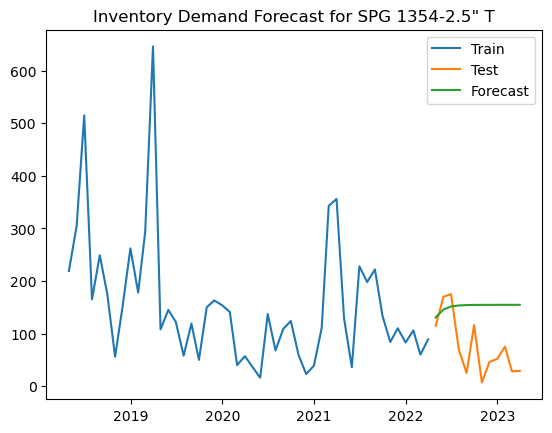

83.77807848602792

In [36]:
# Replace 'item_name' with the name of the item you want to forecast
item_name = "SPG 1354-2.5\" T"
forecast_item_demand(item_name, monthly_data, plot=True)

## Attempting to Predict for All Products > Qty 25 every Month

In [ ]:
# Filter the groups based on the condition that the 'Billed Quantity' is at least 25 every month
filtered_data = monthly_data[monthly_data['Billed Quantity'] >= 25]

# Get unique item names in the filtered DataFrame
unique_items = filtered_data['Item Name'].unique()
      
mae_values = []

if len(unique_items) > 0:
    
    # Apply the forecast_item_demand() function to each unique item
    for item in unique_items:
        mae = forecast_item_demand(item, filtered_data, plot=False)
        if mae is not None:
            mae_values.append(mae)

    # Calculate the mean of all MAEs
    mean_mae = sum(mae_values) / len(mae_values)
    clear_output(wait=True)
    print(f"Mean Absolute Error across all products: {mean_mae:.2f}")
    
else:
    print("No items found with at least 25 units sold every month.")


Skipping 20NB TMF W due to insufficient data.
Skipping ECOLINE 4-300-1 due to insufficient data.
Skipping ECOLINE 4-300-2 due to insufficient data.
